# Loan Prediction - 01 - Exploratory Data Analysis and Pre-cleaning

In [1]:
import sys
sys.path.append('utils')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp

plt.style.use('seaborn')

import dataframe_utils
import preprocess_utils

### Importing and pre-visualization

In [2]:
df_import = pd.read_csv('dataset/train_loan.csv')
display(df_import.head(10))
print(df_import.shape)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


(614, 13)


In [3]:
df_import.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

### Creating New Variables

Let us calculate the base loan installment, that is, the amount paid by month to repay the loan without considering any interest rate.

In [4]:
base_loan_installment = df_import['LoanAmount'] * 1000 / df_import['Loan_Amount_Term']
base_loan_installment.describe()

count     578.000000
mean      480.299850
std       525.458685
min        25.000000
25%       286.111111
50%       365.277778
75%       513.888889
max      9250.000000
dtype: float64

The remaining annual income will be calculated as the total income (Applicants Income + Coapplicant Income) subtracted from the Loan Installment

In [5]:
total_income = df_import['ApplicantIncome'] + df_import['CoapplicantIncome']
remaining_income = (total_income - base_loan_installment) / total_income
remaining_income.describe()

count    578.000000
mean       0.922408
std        0.080790
min       -0.236873
25%        0.918254
50%        0.930888
75%        0.944421
max        0.992992
dtype: float64

Now, let us aggregate these variables to the training dataset and analyse them.

In [6]:
df_import['Base_Loan_Installment'] = base_loan_installment
df_import['Remaining_Income'] = remaining_income

In [7]:
df_import.to_csv('dataset/train_loan_new_variables.csv',index=False)

### Checking valid values

In [8]:
df_import.count()

Loan_ID                  614
Gender                   601
Married                  611
Dependents               599
Education                614
Self_Employed            582
ApplicantIncome          614
CoapplicantIncome        614
LoanAmount               592
Loan_Amount_Term         600
Credit_History           564
Property_Area            614
Loan_Status              614
Base_Loan_Installment    578
Remaining_Income         578
dtype: int64

Each register of the dataset is a client profile for a loan transaction. 

That being said, we will take a more conservative approach and remove all registers with invalid values for now.

In [9]:
df_import_no_nan = df_import.copy().dropna()
df_import_no_nan.count()

Loan_ID                  480
Gender                   480
Married                  480
Dependents               480
Education                480
Self_Employed            480
ApplicantIncome          480
CoapplicantIncome        480
LoanAmount               480
Loan_Amount_Term         480
Credit_History           480
Property_Area            480
Loan_Status              480
Base_Loan_Installment    480
Remaining_Income         480
dtype: int64

### Visualizing categorical data distribution

In [10]:
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History', 'Loan_Amount_Term']
dataframe_utils.show_column_options(df_import[categorical_columns])

Column Values:
Gender : ['Male' 'Female' nan]
Married : ['No' 'Yes' nan]
Dependents : ['0' '1' '2' '3+' nan]
Education : ['Graduate' 'Not Graduate']
Self_Employed : ['No' 'Yes' nan]
Property_Area : ['Urban' 'Rural' 'Semiurban']
Credit_History : [ 1.  0. nan]
Loan_Amount_Term : [360. 120. 240.  nan 180.  60. 300. 480.  36.  84.  12.]


In [11]:
def plot_variable_distribution(df,columns,target_column,title,show_loan_approval = True,n_columns = 4,n_rows = 2):
    if (n_rows * n_columns) != len(columns):
        raise Exception('Columns to be shown must match the number of rows and columns.')
        
    fig, axes = plt.subplots(n_rows,n_columns,figsize=(20, 12))
    fig.suptitle(title,fontsize = 20)
    status_colors = ['#008000','#C24641']
    
    for index,col in enumerate(columns):

        keys = df[col].value_counts().keys()
        if n_rows == 1 or n_columns == 1:
            current_ax = axes[index]
        else:
            row_index = int(index/n_columns)
            col_index = int(index - n_columns*row_index)
            current_ax = axes[row_index][col_index]

        if show_loan_approval:
            approved = df.copy()[df['Loan_Status'] == 'Y'][col]
            approved = approved.value_counts()
            not_approved = df.copy()[df['Loan_Status'] == 'N'][col]
            not_approved = not_approved.value_counts()
            ax = pd.DataFrame({'Loan Approved': approved, 'Loan not Approved': not_approved}).plot(kind='bar', stacked=True,ax = current_ax)
            ax.set_xticklabels(keys)
            ax.set_title(col)

        else:
            unique_counts =  df[col].value_counts().to_list()
            if n_rows == 1 or n_columns == 1:
                axes[index].bar(keys,unique_counts)
                axes[index].set_title(col)
            else:
                axes[row_index][col_index].bar(keys,unique_counts)
                axes[row_index][col_index].set_title(col)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.35)
    plt.show()


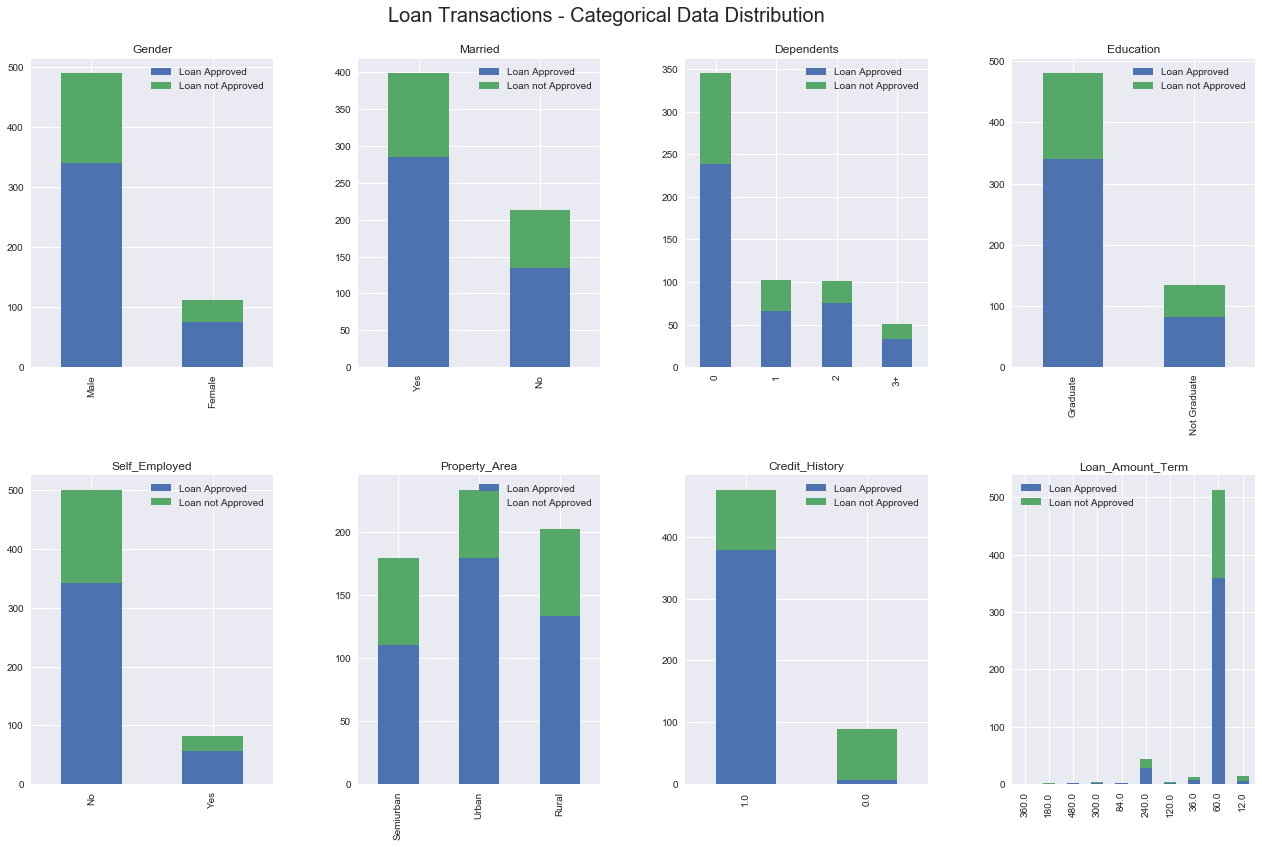

In [12]:
plot_variable_distribution(df_import,categorical_columns,'Loan_Status','Loan Transactions - Categorical Data Distribution',show_loan_approval=True)

In most of the categorical variables, there are no great changes in proportions between loans approved and not approved. For example, the proportion of Male/Female appears to be similar in both approved and not approved loan transactions.

Data shows that the only variable that appears to shift proportions drastically is the Credit_History. Although it makes sense that clients not following the bank guidelines are more prone to not receiving a loan, this is not a mandatory condition.

### Visualizing numerical data

In [13]:
def plot_numerical_distributions(df,columns,title,n_rows = 2,n_columns = 2,figure_size = (20, 12)):
    if (n_rows * n_columns) < len(columns):
        raise Exception('Dataset Variables to be shown must be the equal or smallerthe number of rows and columns.')
    fig, axes = plt.subplots(n_rows,n_columns,figsize=figure_size)
    fig.suptitle(title,fontsize = 20)
    
    for index,col in enumerate(columns):
        
        if n_rows == 1 or n_columns == 1:
            current_ax = axes[index]
        else:
            row_index = int(index/n_columns)
            col_index = int(index - n_columns*row_index)
            current_ax = axes[row_index][col_index]

        
        ax = sns.distplot(df[col], norm_hist=False,ax = current_ax,kde = False) 
        ax.set_title(col)
        label = r'$\mu={:2.2f},\ \sigma={:2.2f},\ median={:2.2f},\ mode={:2.2f}$'.format(df[col].mean(),df[col].std(),df[col].median(),df[col].mode().values[0])
        ax.set_xlabel(label)
#         TODO: Remove blank subplots
#         fig.delaxes(axes.flatten()[i])
    plt.subplots_adjust(top=0.9,hspace = 0.25)    
    plt.show()
    
def plot_numerical_correlation(df,title):
    scatter_matrix = sns.pairplot(df[numerical_columns + ['Loan_Status']],hue='Loan_Status',height = 4);
    scatter_matrix.fig.suptitle('Correlation Between Numerical Variables',fontsize = 20);
    plt.subplots_adjust(top=0.95)

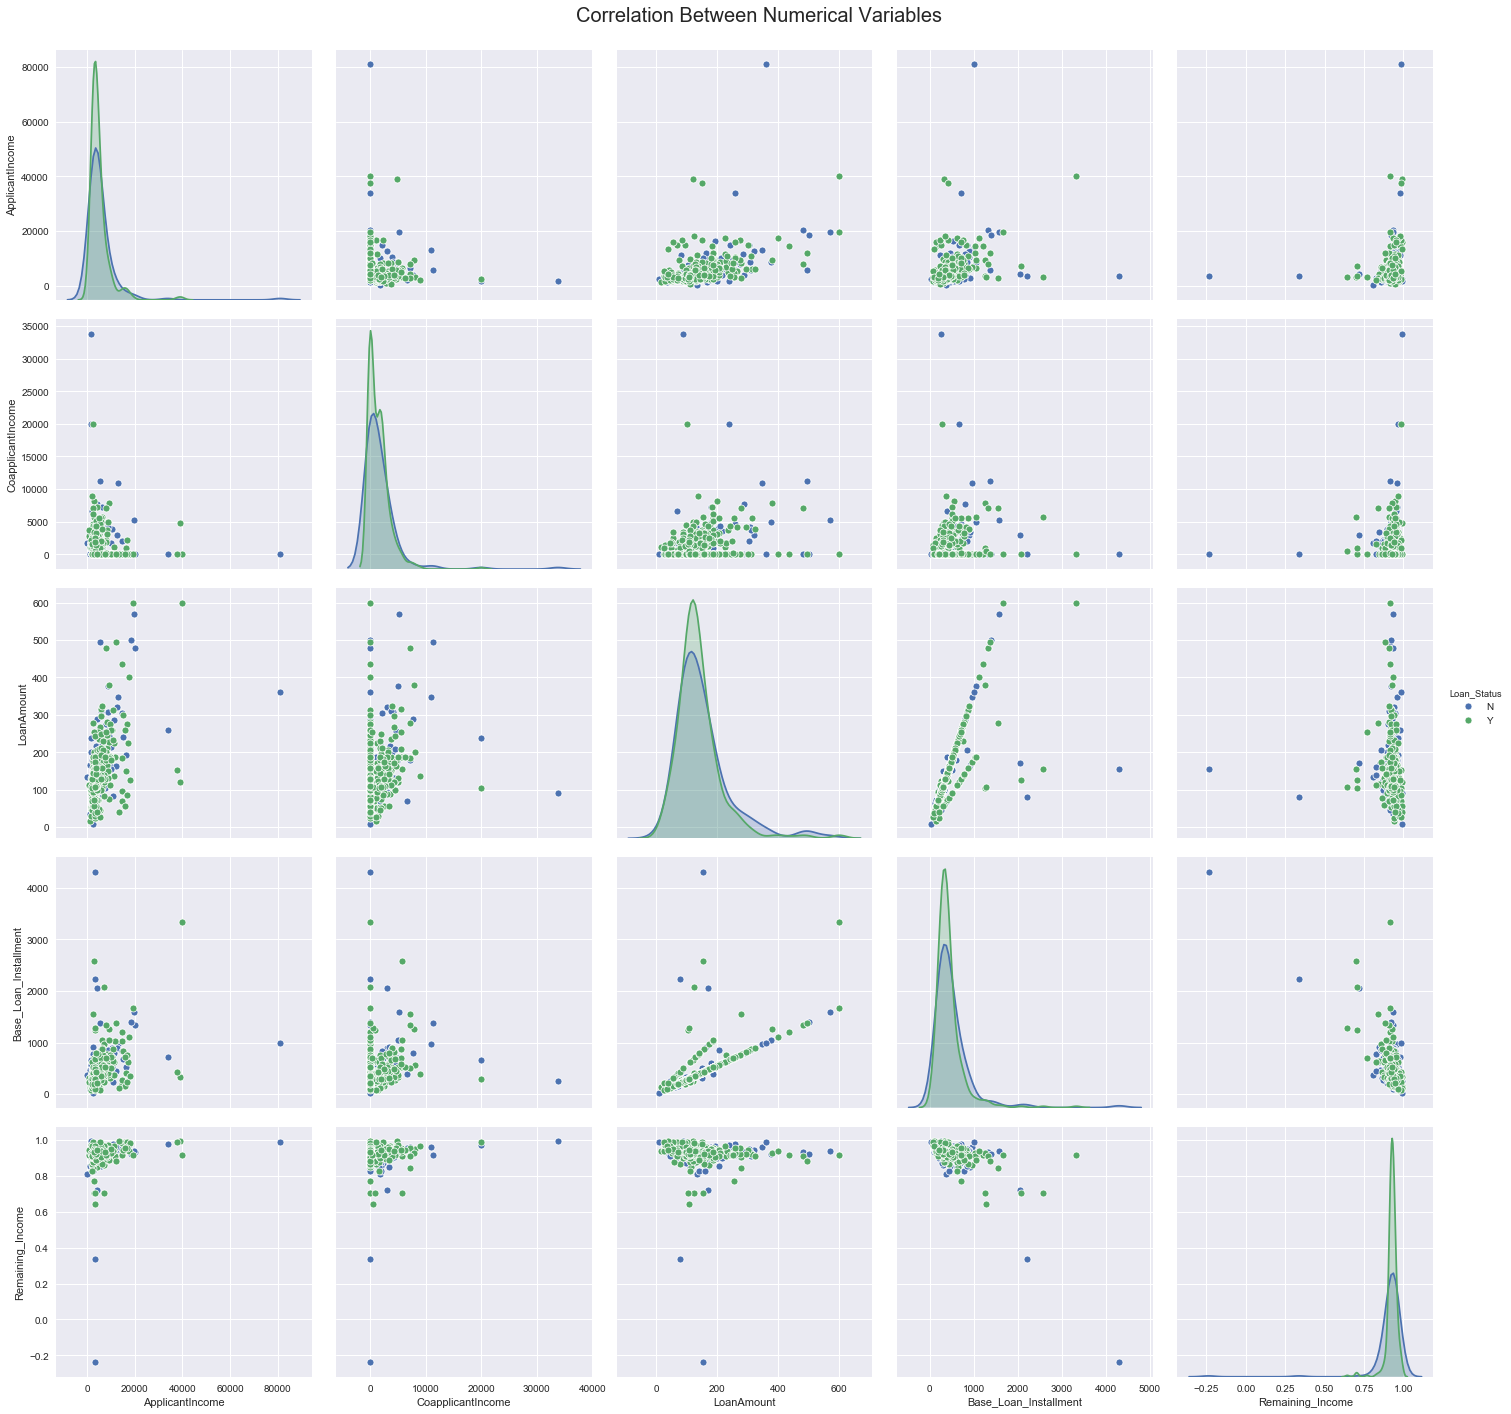

In [14]:
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount','Base_Loan_Installment','Remaining_Income']
plot_numerical_correlation(df_import_no_nan[numerical_columns + ['Loan_Status']],'Correlation Between Numerical Variables')

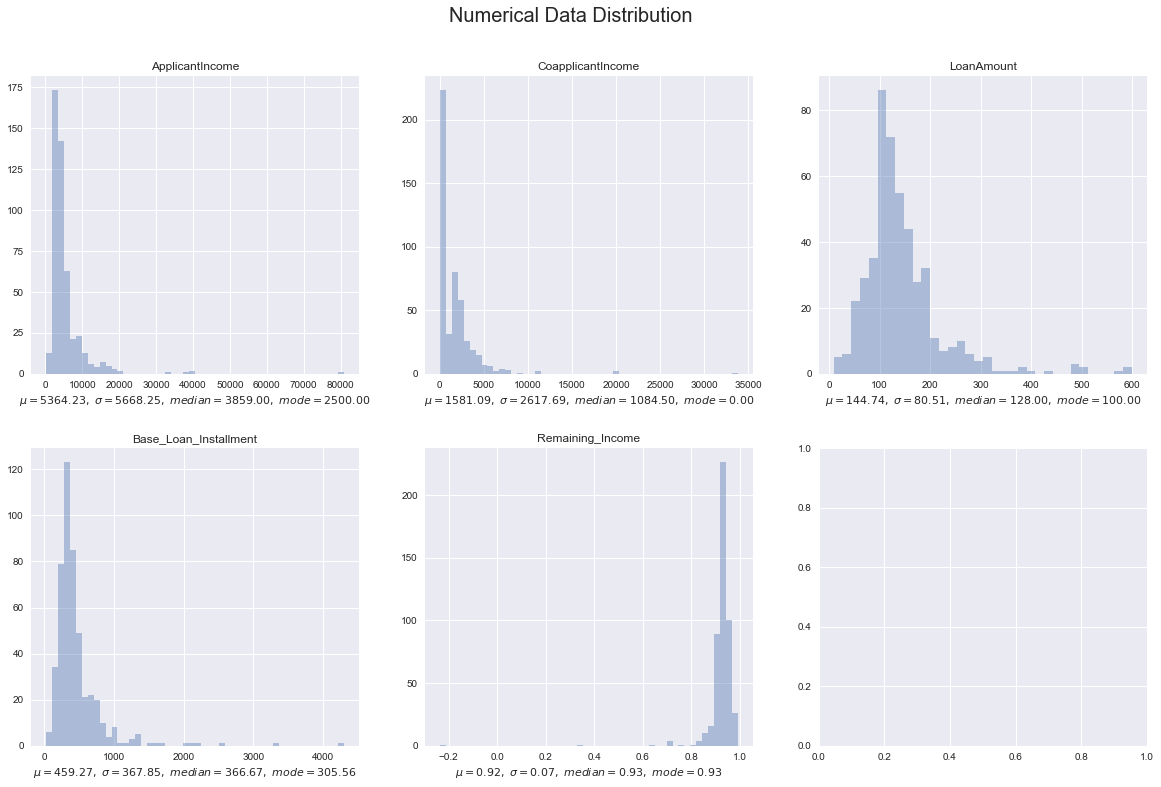

In [15]:
plot_numerical_distributions(df_import_no_nan,numerical_columns,'Numerical Data Distribution',n_rows = 2, n_columns = 3)
df_numerical = df_import_no_nan[numerical_columns].copy()

## Let us analyse numerical data without values exceding 4 standard deviations

In [16]:
df_numerical_no_outlier = preprocess_utils.remove_outliers(df_import_no_nan,numerical_columns,threshold = 4)
display(df_numerical_no_outlier.describe())

(459, 15)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Base_Loan_Installment,Remaining_Income
count,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000,459.000000
mean,4813.930283,1410.553203,137.544662,345.542484,0.854031,411.440329,0.929036
std,3109.442040,1718.727922,62.824143,57.628458,0.353461,208.743633,0.028250
min,150.000000,0.000000,9.000000,84.000000,0.000000,25.000000,0.705119
25%,2885.500000,0.000000,100.000000,360.000000,1.000000,277.777778,0.919117
50%,3846.000000,1126.000000,127.000000,360.000000,1.000000,361.111111,0.931440
75%,5753.000000,2227.500000,165.000000,360.000000,1.000000,497.222222,0.944409
max,18165.000000,10968.000000,436.000000,480.000000,1.000000,1550.000000,0.991622


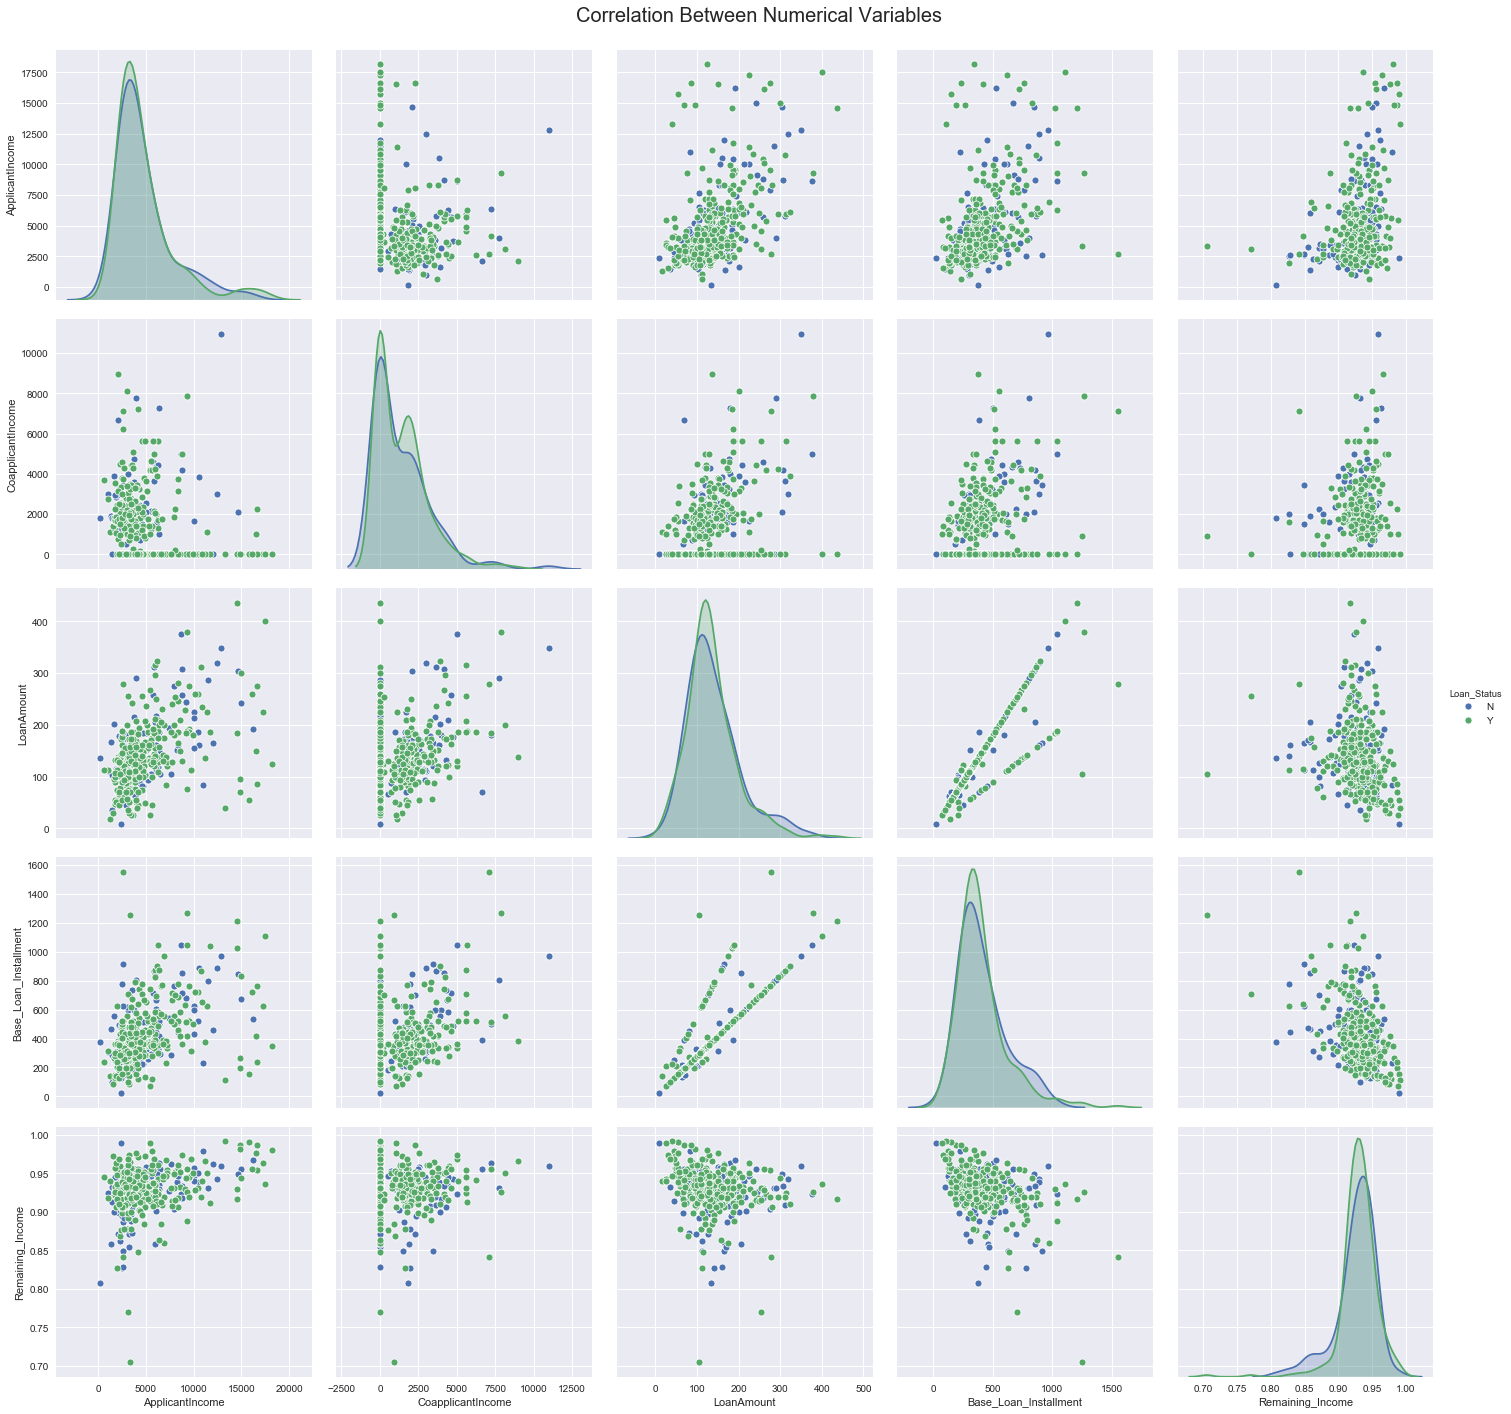

In [17]:
plot_numerical_correlation(df_numerical_no_outlier[numerical_columns + ['Loan_Status']],'Correlation Between Numerical Variables - No Outliers')

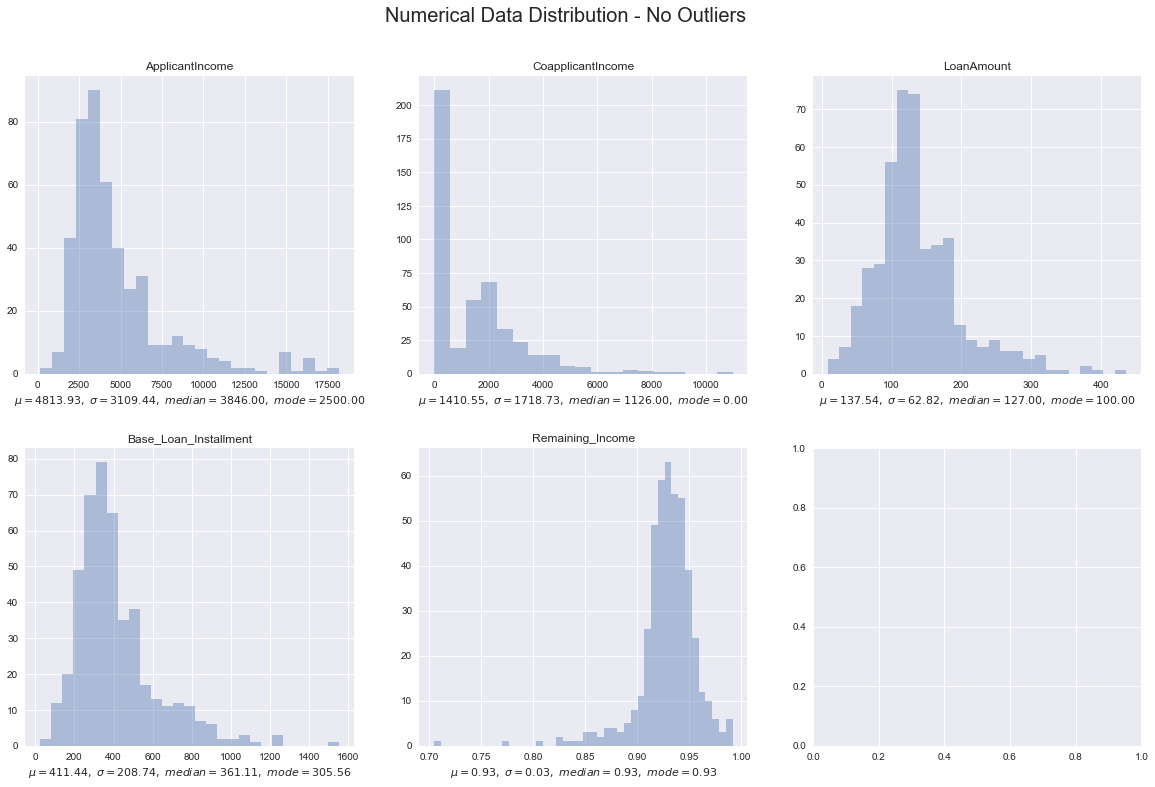

In [18]:
plot_numerical_distributions(df_numerical_no_outlier,numerical_columns,'Numerical Data Distribution - No Outliers',n_rows = 2, n_columns = 3)

## Conclusions

- Most of the clients who did not meet the bank guidelines for Credit_History had their loan applications rejected.
- Most of the applicants income are under 5700.
- Most of the co-applicants income are below 2200 and almost half of them have 0 income.
- Most of the loan terms are 360 months.
- Most of the clients are not self-employed.
- No explict correlation or clusters between any pair of variables (except for the newly created variables).